Project description
===
Here we have a dataset on the process of extraction and purification of gold ore. We aim to build a model for predicting the amount of recovered gold. It would help to optimize production and eliminate unprofitable parameters.

First, we should do some data preprocessing: clean the data, fill in the missing values (if any), and change data types. Next, we need to scale and encode the data. Afterward, we could proceed to model development.

**Description of the data**
```
gold_recovery_train.csv — training dataset 
gold_recovery_test.csv — test dataset 
gold_recovery_full.csv — source dataset 

Technological process:
    Rougher feed — raw material
    Rougher additions (or reagent additions) — flotation reagents: Xanthate, Sulphate, Depressant
        Xanthate — promoter or flotation activator;
        Sulphate — sodium sulphide for this particular process;
        Depressant — sodium silicate.
    Rougher process — flotation
    Rougher tails — product residues
    Float banks — flotation unit
    Cleaner process — purification
    Rougher Au — rougher gold concentrate
    Final Au — final gold concentrate
    
Parameters of stages:
    air amount — volume of air
    fluid levels
    feed size — feed particle size
    feed rate
Feature naming

Naming of the features: [stage].[parameter_type].[parameter_name] (Example: rougher.input.feed_ag)
Possible values for [stage]:
    rougher — flotation
    primary_cleaner — primary purification
    secondary_cleaner — secondary purification
    final — final characteristics
Possible values for [parameter_type]:
    input — raw material parameters
    output — product parameters
    state — parameters characterizing the current state of the stage
    calculation — calculation characteristics

```

## Prepare the data

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import math
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from pprint import pprint

import seaborn as sns

from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_colwidth', None) # no wrap
pd.set_option('display.max_columns', 100) # columns number
pd.set_option('display.max_rows', 50) # rows number

###  Open the files and look into the data

In [4]:
gold_dates = ['date']

try:
    gold_train = pd.read_csv('./datasets/gold_recovery_train.csv', parse_dates=gold_dates)
    gold_test = pd.read_csv('./datasets/gold_recovery_test.csv', parse_dates=gold_dates)
    gold_full = pd.read_csv('./datasets/gold_recovery_full.csv', parse_dates=gold_dates)
except:
    gold_train = pd.read_csv('/datasets/gold_recovery_train.csv', parse_dates=gold_dates)
    gold_test = pd.read_csv('/datasets/gold_recovery_test.csv', parse_dates=gold_dates)
    gold_full = pd.read_csv('/datasets/gold_recovery_full.csv', parse_dates=gold_dates)

In [5]:
for df in [gold_train, gold_test, gold_full]:
    for col in df.columns:
        if col != 'date':
            df[col] = pd.to_numeric(df[col], downcast='float')

In [6]:
gold_train.info()
display(gold_train.describe())
display(gold_train.sample(5))
print()
print('Duplicates in gold_train data: {0}'.format(gold_train.duplicated().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                16860 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         16788 non-null  float32       
 2   final.output.concentrate_pb                         16788 non-null  float32       
 3   final.output.concentrate_sol                        16490 non-null  float32       
 4   final.output.concentrate_au                         16789 non-null  float32       
 5   final.output.recovery                               15339 non-null  float32       
 6   final.output.tail_ag                                16794 non-null  float32       
 7   final.output.tail_pb                                16677 non-null  float32       
 8   final.

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000,16788.000,16490.000,16789.000,15339.000,16794.000,16677.000,16715.000,16794.000,15553.000,15598.000,16860.000,15875.000,16778.000,16502.000,16224.000,16778.000,16777.000,16761.000,16579.000,16777.000,16820.000,16827.000,16820.000,16833.000,16822.000,16833.000,16821.000,16833.000,16833.000,16833.000,16833.000,15618.000,16778.000,16632.000,16347.000,16443.000,16568.000,16777.000,15816.000,16514.000,16237.000,14956.000,16778.000,16778.000,16698.000,16778.000,14287.000,14610.000,16778.000,14611.000,14611.000,16807.000,16807.000,16807.000,16807.000,16807.000,16814.000,16802.000,16809.000,16257.000,16809.000,16802.000,16802.000,16776.000,16764.000,14874.000,16778.000,16497.000,16751.000,16705.000,16748.000,16763.000,16747.000,16752.000,16750.000,16731.000,16747.000,16768.000,16767.000,16775.000,16775.000,16775.000,16776.000,16757.000,16775.000
mean,4.717,9.114,8.301,39.467,67.213,8.757,2.360,9.304,2.688,129.480,8.625,7.297,0.844,7.423,8.620,9.171,29.165,14.917,3.166,6.746,3.591,1521.292,-505.811,1523.880,-507.346,1514.351,-507.094,1468.599,-501.835,-1

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
13194,2018-03-18 17:59:59,4.060,9.180,7.547,48.975,50.010,8.802,2.030,9.091,2.624,137.987,8.963,6.410,1.395,5.203,8.575,6.227,40.960,20.293,5.001,5.189,3.562,1701.617,-499.290,1699.236,-500.212,1697.930,-505.243,1701.255,-441.653,44923.129,2500.852,2500.775,2.259,5.732,2.206,563.204,67.399,29.212,4.983,8.818,6.600,8.817,6.603,11.759,7.295,27.135,19.299,82.180,4.485,0.740,19.337,1.127,1397.363,-300.084,1197.316,-500.869,1098.069,-499.551,1054.698,-501.684,1048.300,-500.432,998.599,-500.826,16.510,10.058,NaN,6.270,37.324,-499.770,26.981,-500.100,28.017,-499.975,19.032,-500.030,23.006,-499.981,14.977,-499.875,18.016,-500.497,12.007,-500.123,12.012,-506.557
2261,2016-04-18 05:00:00,4.664,10.696,6.978,46.153,56.849,8.713,2.225,9.378,2.954,90.654,12.024,6.984,1.294,5.723,4.915,6.459,41.683,15.832,3.611,8.382,5.843,1499.640,-500.543,1503.725,-500.901,1499.147,-503.910,1501.850,-498.910,39650.690,3273.059,3274.899,2.460,7.909,2.567,550.153,54.698,36.873,6.314,11.007,6.703,10.991,7.000,13.491,7.156,34.153,22.166,77.505,5.449,0.604,14.688,1.823,998.900,-500.465,1199


Duplicates in gold_train data: 0


In [7]:
gold_test.info()
display(gold_test.describe())
display(gold_test.sample(5))
print()
print('Duplicates in gold_test data: {0}'.format(gold_test.duplicated().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5856 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5554 non-null   float32       
 2   primary_cleaner.input.depressant            5572 non-null   float32       
 3   primary_cleaner.input.feed_size             5856 non-null   float32       
 4   primary_cleaner.input.xanthate              5690 non-null   float32       
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float32       
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float32       
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float32       
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float32       
 9   primary_

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000,5572.000,5856.000,5690.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5816.000,5834.000,5789.000,5840.000,5599.000,5733.000,5801.000,5503.000,5839.000,5840.000,5839.000,5840.000,5839.000,5840.000,5839.000,5840.000,5839.000,5840.000,5839.000,5840.000,5836.000,5840.000,5833.000,5840.000,5822.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000
mean,170.515,8.483,7.265,1.321,1481.990,-509.058,1486.909,-511.744,1468.495,-509.741,1486.399,-510.724,8.736,3.553,458.485,55.938,35.106,8.701,13.440,6.170,13.056,6.424,1016.295,-404.978,1270.599,-482.155,1253.495,-480.946,1169.676,-482.152,1018.386,-476.552,962.005,-477.795,25.480,-513.715,21.083,-512.326,24.346,-519.418,20.068,-515.028,15.636,-516.266,13.146,-476.339,12.309,-512.208,9.471,-505.018,16.679,-512.352
std,49.609,3.353,0.612,0.693,310.453,61.339,313.224,67.139,309.981,62.672,313.725,65.418,2.986,1.326,155.958,22.724,10.793,2.803,3.998,1.674,4.534,1.120,226.495,100.954,285.248,55.400,290.703,53.759,285.407,54.968,231.676,67.003,220.862,68.342,5.450,62.448,5.940,63.377,7.951,73.968,7.644,60.458,4.661,62.757,4.304,105.549,3.763,58.865,3.312,68.786,5.405,69.920
min,0.000,0.000,5.650,0.000,0.000,-799.774,0.000,-800.029,0.000,-799.995,0.000,-799.839,0.000,0.000,0.003,0.046,0.000,0.000,0.000,0.000,0.000,0.000,-0.123,-657.950,-0.822,-650.349,-0.282,-650.000,-1.047,-648.391,-2.077,-650.153,-2.593,-650.035,0.000,-799.609,0.000,-798.467,0.000,-799.756,0.000,-809.333,0.000,-799.799,0.000,-800.837,-0.223,-799.661,0.528,-800.220,-0.079,-809.860
25%,143.340,6.411,6.886,0.889,1497.191,-500.455,1497.150,-500.937,1437.050,-501.300,1498.407,-500.554,7.599,3.079,399.782,43.891,33.382,7.764,11.006,5.884,10.999,5.994,998.971,-499.971,1199.501,-500.328,1195.460,-500.311,1004.580,-500.583,998.871,-500.269,900.519,-500.769,24.909,-500.244,19.965,-500.253,22.034,-500.368,15.980,-500.173,12.058,-501.055,11.880,-500.419,10.123,-500.879,7.991,-500.223,13.012,-500.834
50%,176.104,8.023,7.259,1.183,1554.660,-499.997,1553.268,-500.067,1546.161

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
3333,2017-09-17 21:59:59,204.209,8.536,7.150,1.623,1599.594,-499.903,1599.974,-498.690,1600.649,-498.214,1598.687,-499.541,7.425,3.151,587.308,58.349,42.589,7.867,17.001,7.337,17.001,7.332,1006.250,-299.777,1299.038,-499.730,1250.323,-500.119,1200.518,-499.520,999.875,-499.792,999.621,-499.353,27.952,-497.794,23.012,-406.976,18.015,-500.734,14.010,-500.355,12.005,-502.249,8.916,-401.636,9.018,-501.323,7.018,-500.837,10.039,-503.676
4046,2017-10-17 14:59:59,157.880,6.490,6.275,2.205,1502.027,-499.428,1501.663,-496.629,1502.204,-501.231,1500.070,-499.094,6.550,3.261,461.488,52.683,40.583,7.210,16.003,5.986,16.001,5.985,979.003,-299.691,1100.487,-500.337,1050.060,-499.335,1008.079,-499.907,900.028,-499.186,901.464,-499.882,25.004,-500.402,23.049,-499.977,21.986,-500.093,19.960,-499.851,18.037,-500.052,15.862,-400.203,13.043,-500.607,9.996,-500.104,14.000,-500.272
1982,2016-11-22 14:59:59,212.815,5.979,7.160,1.722,1600.703,-500.141,1600.125,-500.791,1600.074,-500.468,1600.617,-500.166,10.099,3.182,450.374,44.429,36.760,10.007,13.001,6.100,13.000,6.098,1002.564,-500.266,1501.992,-400.322,1499.804,-400.935,1399.867,-400.504,1199.421,-402.318,1099.301,-400.076,26.926,-498.669,24.897,-499.528,0.131,-799.570,0.000,-758.764,18.036,-500.267,15.995,-499.553,15.726,-499.801,11.997,-499.948,21.985,-500.136
5765,2017-12-28 05:59:59,196.432,15.993,8.650,0.904,1432.174,-400.177,1431.973,-402.792,1429.480,-401.518,1428.353,-399.700,11.289,5.524,501.415,65.647,41.877,10.850,11.140,6.677,11.139,6.670,1400.635,-299.674,1202.764,-499.452,1103.750,-499.525,1001.889,-500.589,899.278,-500.636,899.963,-498.702,28.913,-499.285,26.916,-499.650,27.970,-499.331,22.998,-500.033,19.999,-498.340,14.976,-498.998,11.039,-499.567,9.010,-499.947,12.017,-500.341
4632,2017-11-11 00:59:59,148.685,9.959,8.470,1.892,1598.160,-503.205,1601.798,-502.644,1478.193,-495.569,1599.839,-502.907,10.087,2.745,651.126,87.186,42.221,8.707,14.062,7.699,14.066,7.702,1196.871,-300.067,1404.077,-500.062,1347.544,-501.034,1250.294,-500.562,1149.855,-500.498,1050.222,-501.591,26.903,-499.546,24.920,-499.957,23.030,-499.639,17.997,-499.957,17.0


Duplicates in gold_test data: 0


In [8]:
gold_full.info()
display(gold_full.describe())
display(gold_full.sample(5))
print()
print('Duplicates in gold_full data: {0}'.format(gold_full.duplicated().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                22716 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         22627 non-null  float32       
 2   final.output.concentrate_pb                         22629 non-null  float32       
 3   final.output.concentrate_sol                        22331 non-null  float32       
 4   final.output.concentrate_au                         22630 non-null  float32       
 5   final.output.recovery                               20753 non-null  float32       
 6   final.output.tail_ag                                22633 non-null  float32       
 7   final.output.tail_pb                                22516 non-null  float32       
 8   final.

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22627.000,22629.000,22331.000,22630.000,20753.000,22633.000,22516.000,22445.000,22635.000,21107.000,21170.000,22716.000,21565.000,22618.000,22268.000,21918.000,22618.000,22614.000,22594.000,22365.000,22617.000,22660.000,22667.000,22660.000,22673.000,22662.000,22673.000,22661.000,22673.000,22672.000,22672.000,22672.000,21089.000,22618.000,22472.000,22163.000,22277.000,22357.000,22617.000,21415.000,22247.000,22038.000,20459.000,22618.000,22618.000,22526.000,22618.000,19597.000,19979.000,22618.000,19980.000,19980.000,22646.000,22647.000,22646.000,22647.000,22646.000,22654.000,22641.000,22649.000,22096.000,22649.000,22641.000,22642.000,22616.000,22600.000,20501.000,22618.000,22333.000,22591.000,22538.000,22588.000,22585.000,22587.000,22592.000,22590.000,22571.000,22587.000,22608.000,22607.000,22615.000,22615.000,22615.000,22616.000,22597.000,22615.000
mean,4.782,9.095,8.640,40.001,67.447,8.924,2.488,9.524,2.827,140.278,8.588,7.289,0.970,7.692,8.921,9.574,29.212,14.876,3.176,7.208,3.670,1511.163,-506.648,1514.352,-508.479,1502.534,-507.776,1473.186,-504.125,-6

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
7522,2016-11-23 09:59:59,8.149,8.177,13.645,39.386,69.532,11.483,2.975,9.932,3.729,190.079,6.934,7.380,1.827,11.985,10.053,14.512,28.520,17.107,3.792,11.200,4.179,1596.214,-500.167,1603.204,-500.435,1598.654,-499.592,1598.915,-499.855,48950.110,3177.240,3176.701,3.073,10.188,3.275,449.417,44.481,34.357,10.066,14.000,5.999,14.000,5.999,12.672,6.291,24.041,19.718,89.180,6.824,0.441,19.339,1.999,997.058,-499.641,1446.667,-400.066,1447.312,-399.657,1393.293,-399.820,1100.437,-403.200,999.956,-397.907,15.730,4.694,8.813,6.474,27.001,-499.892,24.907,-500.275,0.000,-799.488,0.000,-755.265,18.006,-497.211,15.877,-449.680,15.423,-498.746,11.978,-495.815,21.992,-499.664
9087,2017-01-27 14:59:59,4.388,9.541,15.523,45.990,72.959,11.165,3.195,9.681,2.972,154.435,9.996,7.580,0.697,8.770,11.363,12.878,33.651,19.326,4.238,7.681,2.917,1603.194,-499.641,1601.103,-500.022,1598.152,-497.312,1600.069,-500.845,45052.904,3090.836,3091.253,2.617,10.002,3.576,427.873,55.393,35.063,9.360,12.003,5.700,12.000,5.701,16.267,7.986,35.350,22.488,88.544,5.977,0.349,15.445,1.698,1000.443,-


Duplicates in gold_full data: 0


**Conclusion**

There are some missing values in this dataset. However, knowing that parameters next to each other in terms of time are often similar, we could fill these missing values.

After the first investigation, we changed the date data type while reading from the file and downcasted floats. 

We don't have any complete duplicates in this data set.

###  Check that recovery is calculated correctly

In [9]:
def recovery(df, C, F, T):
    rec = 100 * ((df[C] * (df[F] - df[T])) / (df[F] * (df[C] - df[T])))
    return rec

recovery_predicted = recovery(gold_train.dropna(subset=['rougher.output.recovery']), 'rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au')
recovery_actual = gold_train['rougher.output.recovery'].dropna().to_list()

print(f"Mean Absolute Error: {mean_absolute_error(recovery_actual, recovery_predicted)}")

Mean Absolute Error: 3.973648547625587e-06


**Conclusion**  
We used the part of the training set that doesn't contain missing values in `rougher.output.recovery` and the following formula:

${Recovery = }\frac{C*(F-T)}{F*(C-T)}*100\%$

    C = Concentrate after process
    F = Concentrate before process
    T = Tails after process

The Mean Absolute Error between our result and the provided one is about 3.97e-06, which is a small value.

---

###  Analyze the features not available in the test set

In [10]:
not_in_test = [x for x in gold_full.columns if x not in gold_test.columns]
pprint(not_in_test)

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

In [11]:
gold_test = pd.merge(gold_test, gold_full[['date', 'final.output.recovery', 'rougher.output.recovery']],
                     on='date', how='left')

gold_train = gold_train.drop(columns=[x for x in gold_train if x not in gold_test], axis=1)

**Conclusion**  
We have some features included in the `gold_train` and `gold_full` dataframes but missing from the `gold_test` dataframe. They represent the values that are unknown before the purification process. Including them in the training set would lead to information leakage, so we should drop them. Also, in the test dataframe, we don't have our targets. They could be obtained from the `gold_full` dataframe by date.

---

### Perform data preprocessing

In [12]:
print(f"Rows with missing values in the gold_train dataset: {gold_train.isnull().any(axis=1).sum()/gold_train.shape[0]:.2%}")
print()
print(f"Rows with missing values in the gold_test dataset: {gold_test.isnull().any(axis=1).sum()/gold_test.shape[0]:.2%}")

Rows with missing values in the gold_train dataset: 24.80%

Rows with missing values in the gold_test dataset: 10.71%


In [13]:
fill_columns = [x for x in gold_train.columns if x not in ['date', 'rougher.output.recovery', 'final.output.recovery']]

gold_train[fill_columns] = gold_train[fill_columns].fillna(method='ffill')
gold_test[fill_columns] = gold_test[fill_columns].fillna(method='ffill')

print(f"Rows with missing values in the targets of the gold_train dataset: {gold_train.isnull().any(axis=1).sum()/gold_train.shape[0]:.2%}")
print()
print(f"Rows with missing values in the targets of the gold_test dataset: {gold_test.isnull().any(axis=1).sum()/gold_test.shape[0]:.2%}")

Rows with missing values in the targets of the gold_train dataset: 16.08%

Rows with missing values in the targets of the gold_test dataset: 9.67%


In [14]:
gold_train = gold_train.dropna().reset_index(drop=True)
gold_test = gold_test.dropna().reset_index(drop=True)

**Conclusion**  
Knowing that parameters next to each other in terms of time are often similar, we could fill in the missing values in feature columns using the ffill method. However, we could not use the same approach to fill in the target variables because it could lead to information leakage. So we dropped the rows with nulls in the targets.   

---

## Analyze the data

### Changes of the metals' concentrations on different purification stages

In [15]:
stages = ['rougher.input.feed', 
          'rougher.output.concentrate', 
          'primary_cleaner.output.concentrate', 
          'final.output.concentrate']

metals = {'_au' : 'Au', '_ag' : 'Ag', '_pb' : 'Pb'}

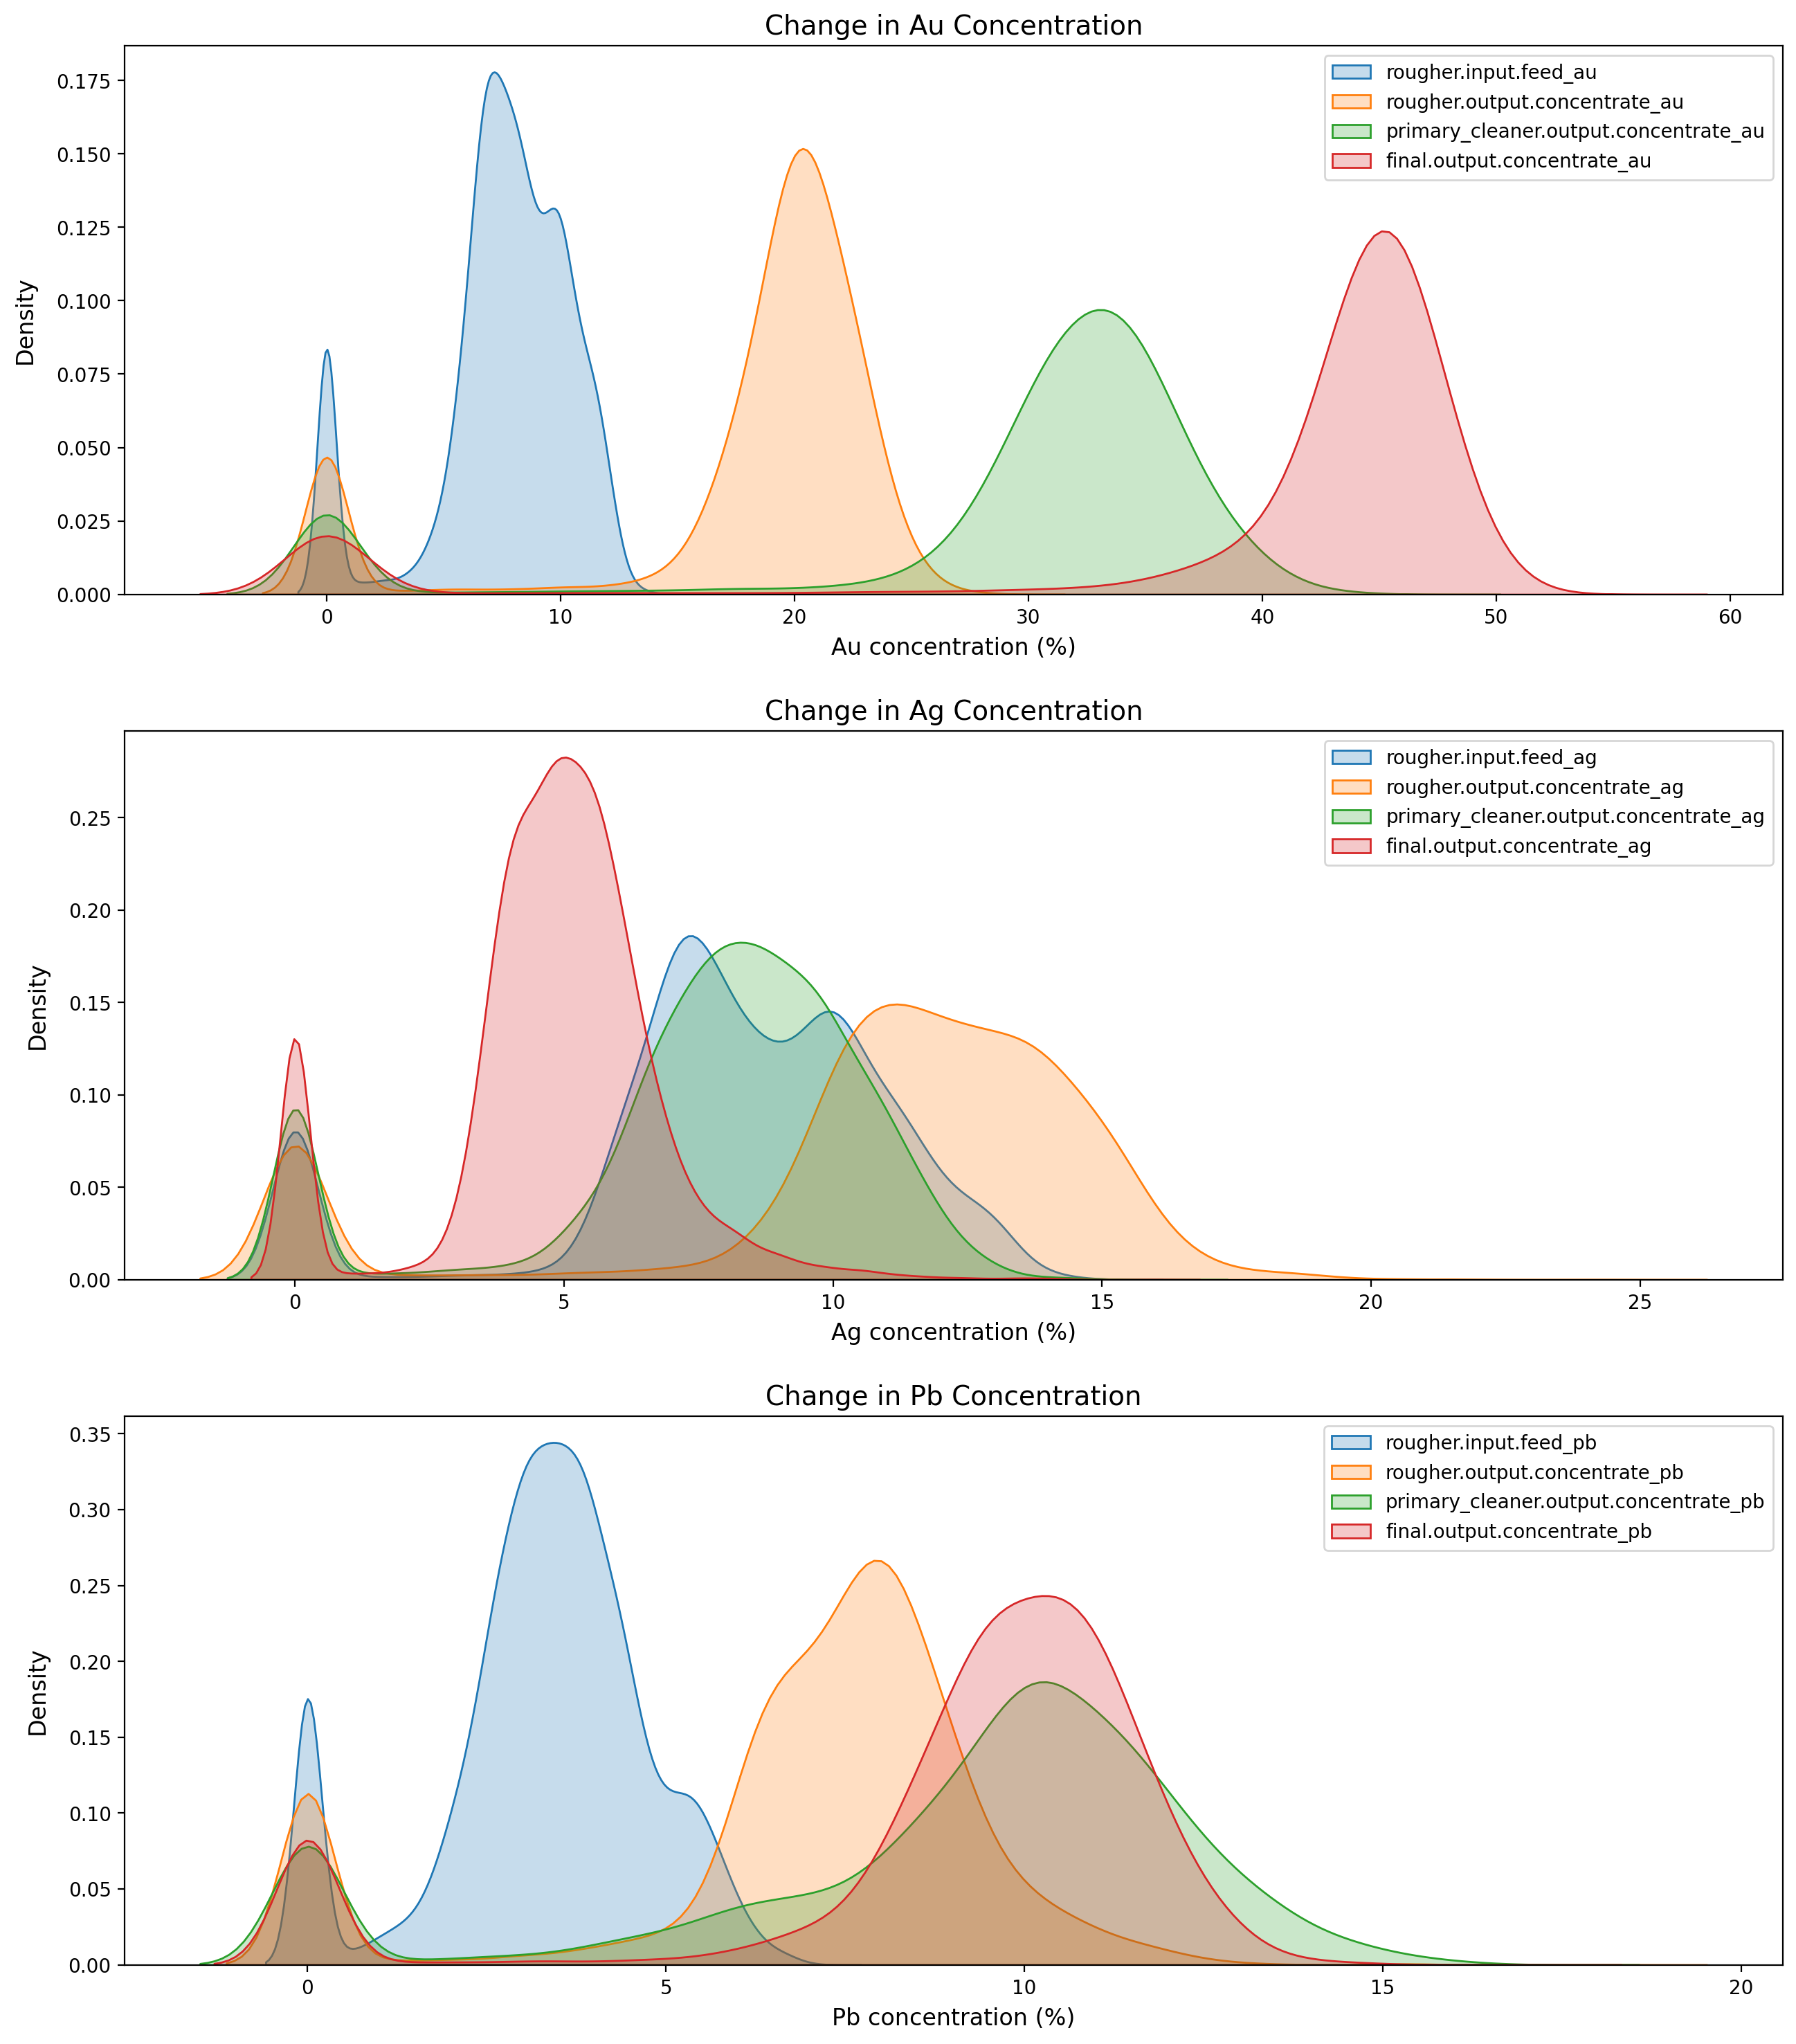

In [16]:
fig, axes = plt.subplots(3, 1, figsize=(13, 15))
plt.subplots_adjust(hspace = 15);

for i, met in enumerate(metals.keys()):
    for stage in stages:
        sns.kdeplot(gold_full[f'{stage}{met}'], ax=axes[i], shade='fill', label=f'{stage}{met}')
        axes[i].legend()
        axes[i].set_title(f'Change in {metals[met]} Concentration', fontsize=14)
        axes[i].set_xlabel(f'{metals[met]} concentration (%)', fontsize=12, labelpad=5)
        axes[i].set_ylabel('Density', fontsize=12, labelpad=10)

plt.tight_layout()
plt.show()

**Conclusion**  
Here we can see that the concentration of gold increases after each stage (from less than 10% to ~45%), which is adequate since it is the purpose of the whole process.  
The concentration of silver increases on the first step but goes down in the next two steps, and the final concentration is lower than the starting one.  
The concentration of lead goes up in the first, second and third stages and stays there. 

Also, here we can see that we have concentrations of about zero for each metal and on each of the stages. These outliers could indicate some problems with the data.

---

### Feed particle size distributions in the training and test sets

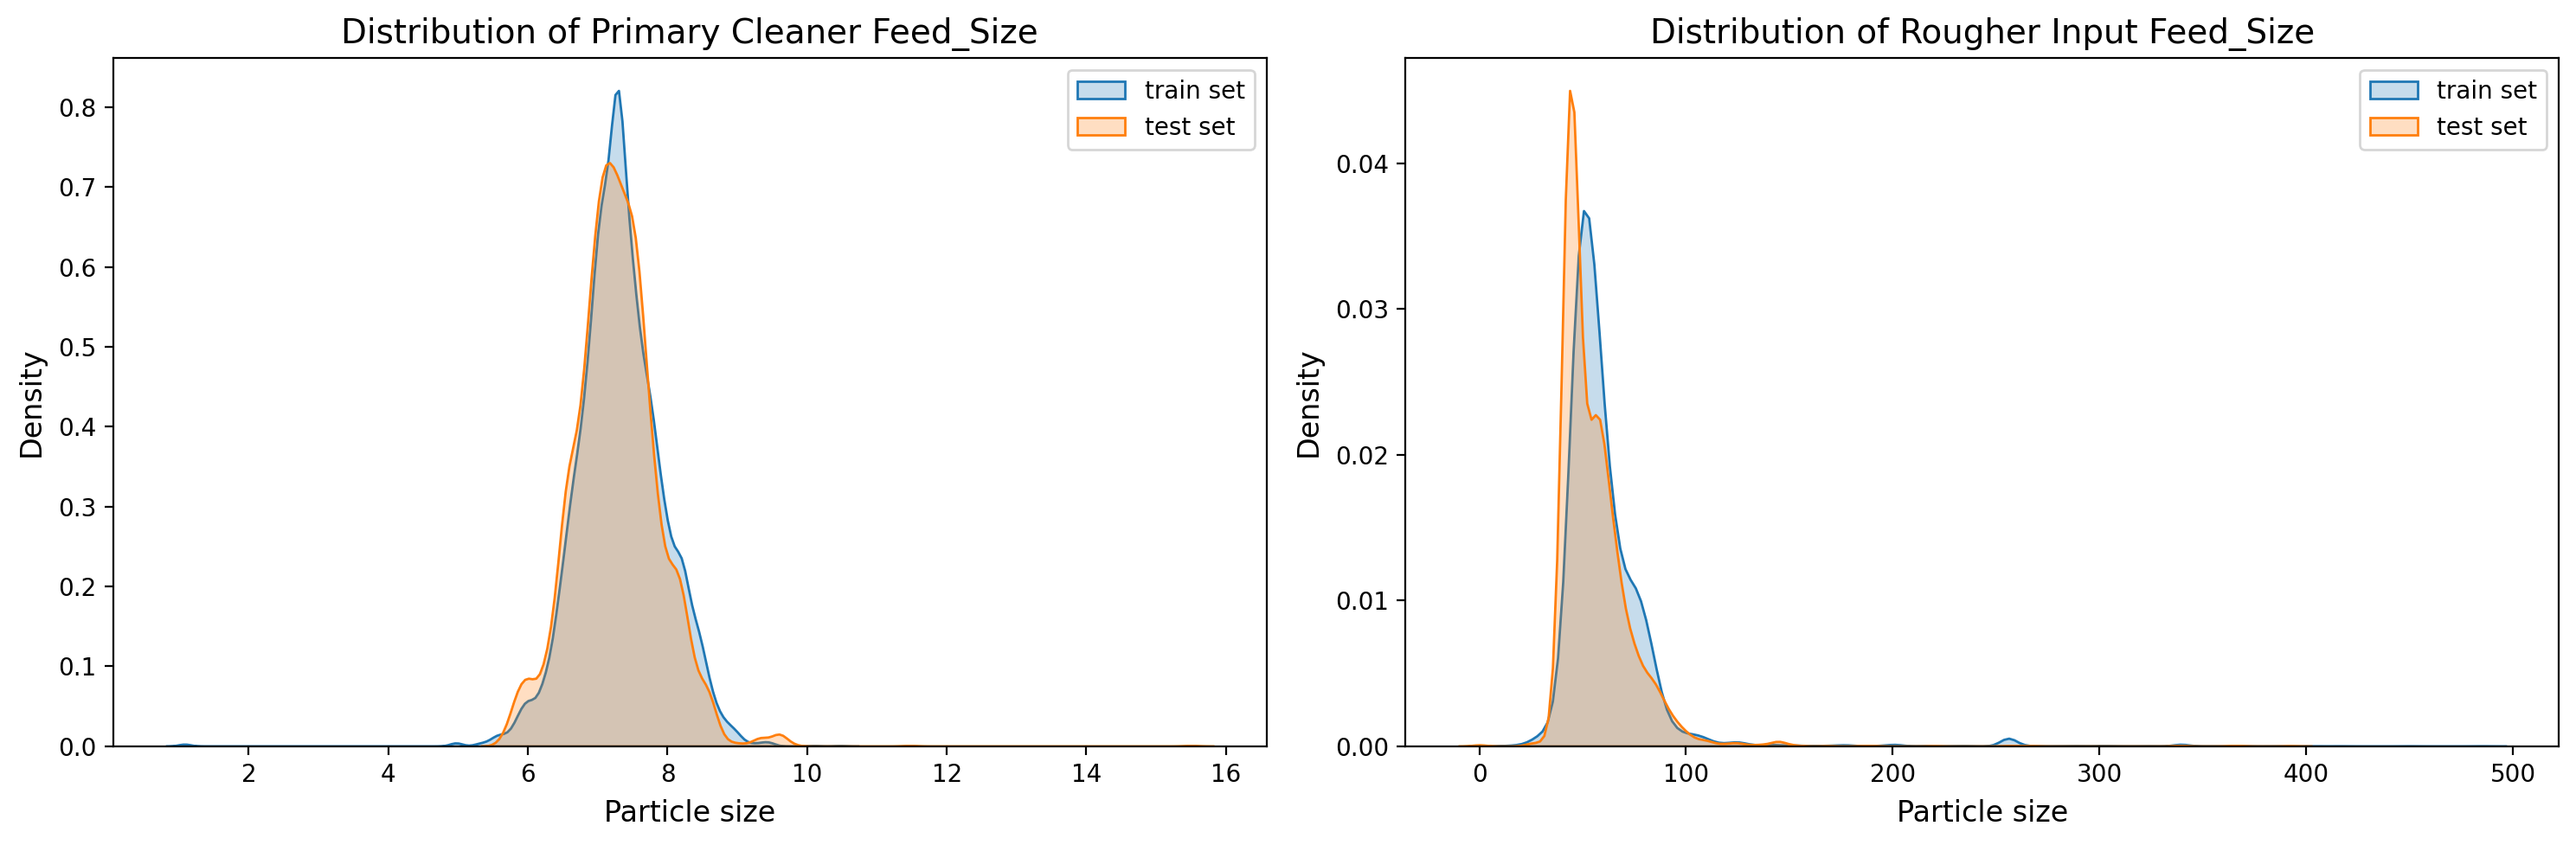

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(gold_train['primary_cleaner.input.feed_size'], fill=True, label='train set', ax=ax[0])
sns.kdeplot(gold_test['primary_cleaner.input.feed_size'], fill=True, label='test set', ax=ax[0])
ax[0].set_title('Distribution of Primary Cleaner Feed_Size', fontsize=14)
ax[0].set_xlabel('Particle size', fontsize=12, labelpad=5)
ax[0].set_ylabel('Density', fontsize=12, labelpad=5);
ax[0].legend()

sns.kdeplot(gold_train['rougher.input.feed_size'], fill=True, label='train set', ax=ax[1])
sns.kdeplot(gold_test['rougher.input.feed_size'], fill=True, label='test set', ax=ax[1])
ax[1].set_title('Distribution of Rougher Input Feed_Size', fontsize=14)
ax[1].set_xlabel('Particle size', fontsize=12, labelpad=5)
ax[1].set_ylabel('Density', fontsize=12, labelpad=5);
ax[1].legend()

plt.tight_layout()
plt.show()

**Conclusion**  
Comparing the distributions of `primary_cleaner.input.feed_size` and `rougher.input.feed_size` variables from the training and the test sets, we could see that they are roughly the same. If they vary significantly, the model evaluation will be incorrect.

---

### Combined concentrations of all metals at different stages

In [18]:
stages.remove('primary_cleaner.output.concentrate')

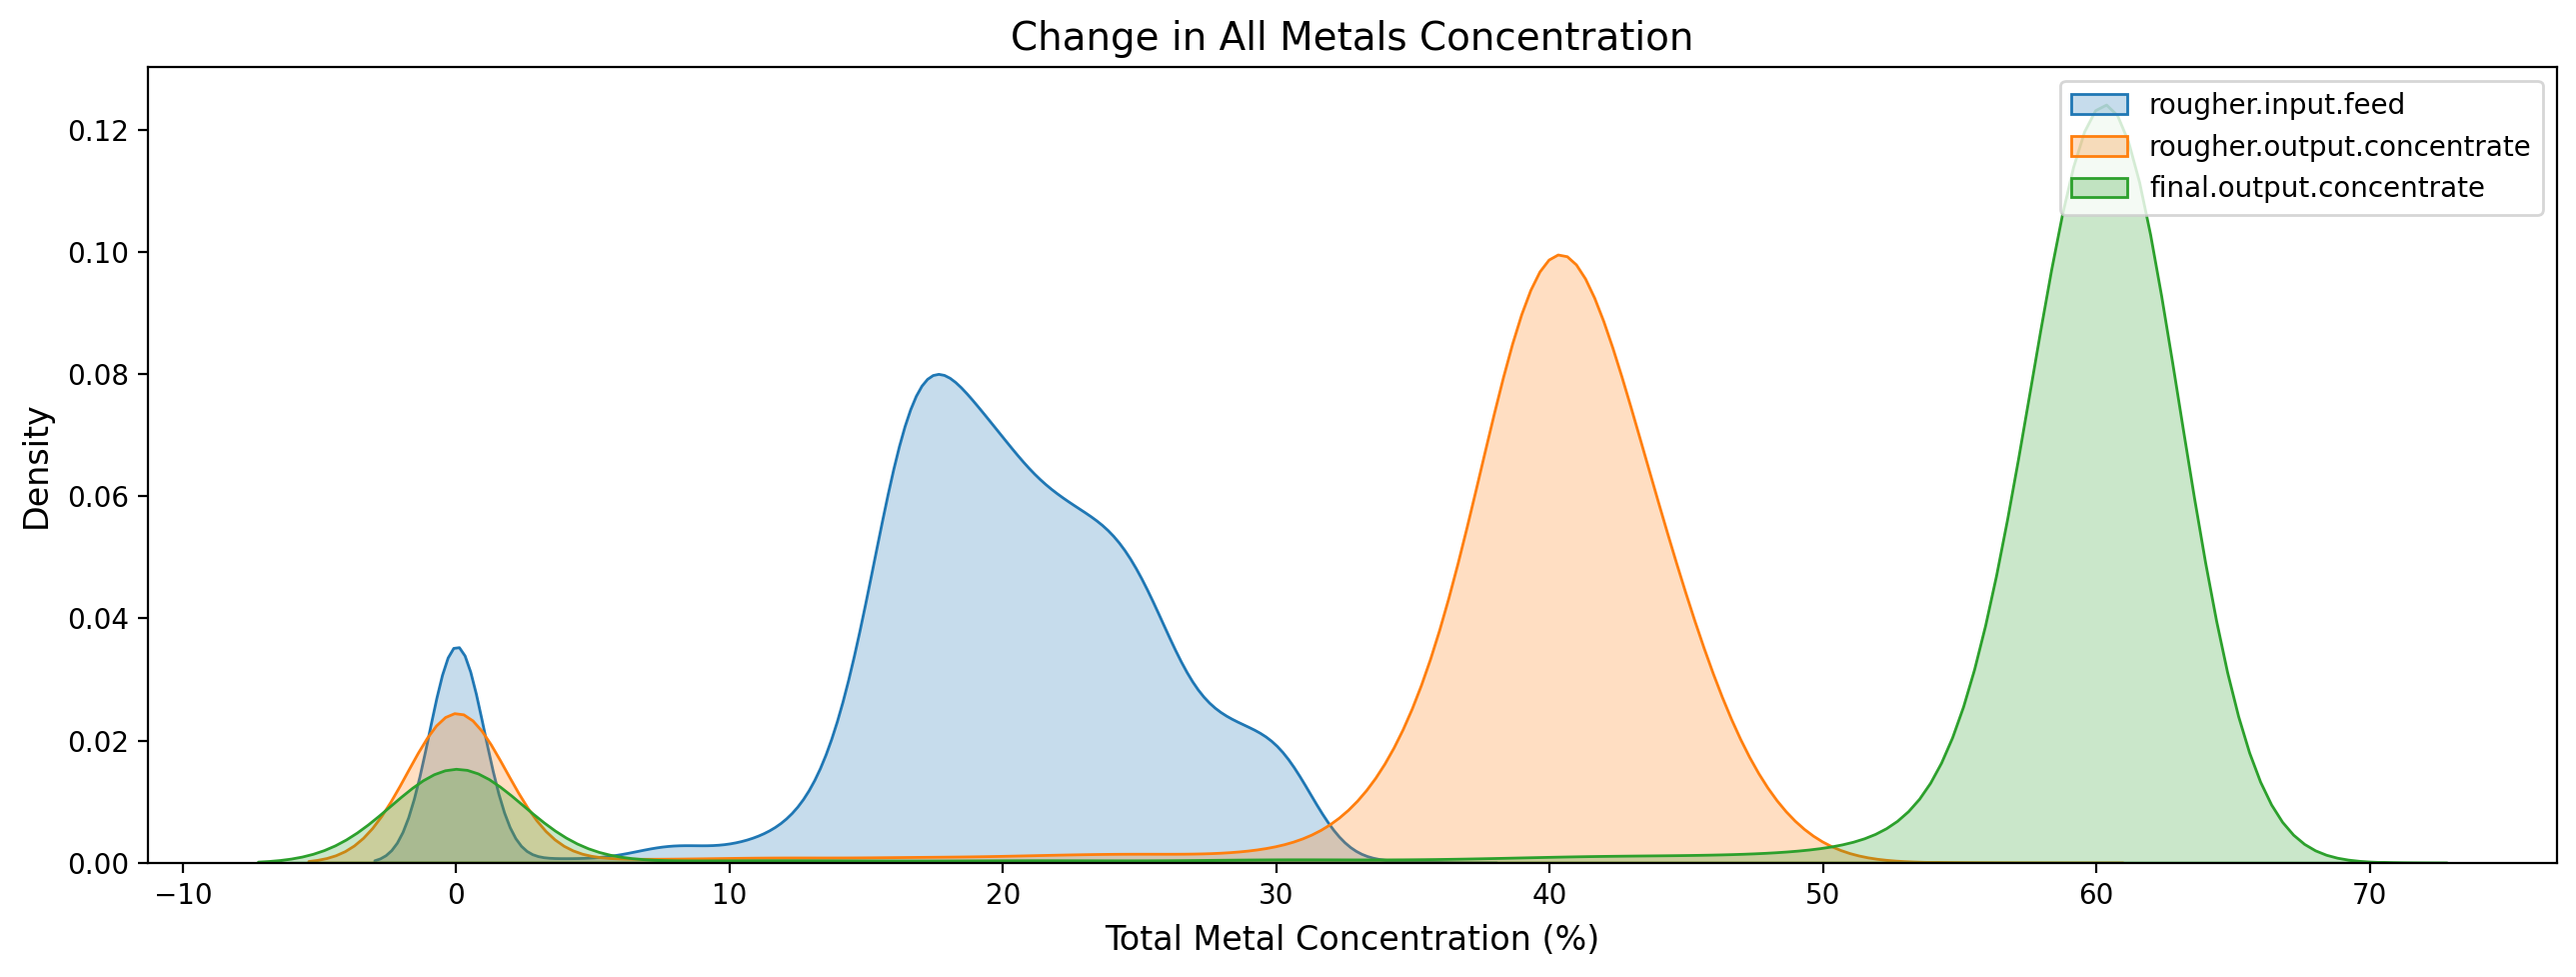

In [19]:
fig = plt.figure(figsize=(13, 5))

for stage in stages:
    sns.kdeplot(gold_full[[f'{stage}{m}' for m in metals.keys()]].sum(axis=1), label=stage, fill=True)

plt.legend()
plt.title('Change in All Metals Concentration', fontsize=14)
plt.xlabel('Total Metal Concentration (%)', fontsize=12, labelpad=5)
plt.ylabel('Density', fontsize=12, labelpad=5)
plt.tight_layout()
plt.show()

**Conclusion**  
Looking at the concentration of all metals combined at different stages: 'raw feed', 'rougher concentrate', and 'final concentrate', we could see that it is generally increasing. But we have some entries where the concentration is about zero. For more accurate results in building the models, we should remove these outliers from training and testing sets. The suitable threshold seems to be less than 10.

In [20]:
outliers_filter = []
for stage in stages:
    outliers_filter.append([f'{stage}{m}' for m in metals.keys()])

good_entries = gold_full[(gold_full[outliers_filter[0]].sum(axis=1) > 10) \
                 & (gold_full[outliers_filter[1]].sum(axis=1) > 10)\
                 & (gold_full[outliers_filter[2]].sum(axis=1) > 10)]['date']

oldlen = gold_train.shape[0]
print('Starting train set length:', oldlen)
gold_train_cleaned = gold_train[gold_train['date'].isin(good_entries)].reset_index(drop=True)
print('Cleaned train set length:', gold_train_cleaned.shape[0])
print(f'Removed {(100 - (gold_train_cleaned.shape[0] / oldlen)*100):.2f}% of entries')
print()
oldlen = gold_test.shape[0]
print('Starting test set length:', oldlen)
gold_test_cleaned = gold_test[gold_test['date'].isin(good_entries)].reset_index(drop=True)
print('Cleaned test set length:', gold_test_cleaned.shape[0])
print(f'Removed {(100 - (gold_test_cleaned.shape[0] / oldlen)*100):.2f}% of entries')

Starting train set length: 14149
Cleaned train set length: 13650
Removed 3.53% of entries

Starting test set length: 5290
Cleaned test set length: 5133
Removed 2.97% of entries


In [21]:
X_train = gold_train_cleaned[fill_columns]
X_test = gold_test_cleaned[fill_columns]


y_train = gold_train_cleaned[['rougher.output.recovery', 'final.output.recovery']].values
y_test = gold_test_cleaned[['rougher.output.recovery', 'final.output.recovery']].values

**Conclusion**  
Since we don't have the output concentrations in train and test dataframes (to prevent information leakage), we excluded the entries containing outliers through the `gold_full` dataframe. 
Also, here we scaled our train and test dataframes.

---

## Build the model

### Function to calculate the final sMAPE value

In [22]:
def smape_func(y_true, y_pred):
    smape = np.mean(abs(y_pred - y_true) / ((abs(y_true) + abs(y_pred)) / 2)) * 100
    return smape

def final_smape_func(y_true, y_pred):
    predicted_rough, predicted_final = y_pred[:, 0], y_pred[:, 1]
    true_rough, true_final = y_true[:, 0], y_true[:, 1]
    f_smape = (.25 * (smape_func(true_rough, predicted_rough))) + (.75 * (smape_func(true_final, predicted_final)))
    return f_smape

---
### Training and evaluating different models

In [23]:
smape = make_scorer(final_smape_func, greater_is_better=False)

def fit_score(model, pref, params, name):
    pipe = Pipeline([('scaler', StandardScaler()), (pref, model)])
    model = GridSearchCV(pipe, param_grid=params, cv=5, scoring=smape, verbose=0, refit=True)
    model.fit(X_train, y_train)
    return pd.DataFrame([[name, abs(model.best_score_), model.best_params_]], \
                        columns=['Estimator', 'Best Score', 'Params'])

In [24]:
%%time
LinearRegressor = fit_score(LinearRegression(), 'lr', {}, 'Linear Regressor')

CPU times: user 941 ms, sys: 528 ms, total: 1.47 s
Wall time: 275 ms


In [25]:
%%time
LassoRegressor = fit_score(Lasso(random_state=12345), 'las', \
                           {'las__alpha' : np.arange(.01, 1, .05)}, 'Lasso Regressor')

CPU times: user 25.8 s, sys: 9.61 s, total: 35.4 s
Wall time: 5.7 s


In [26]:
%%time
KNNeighbors = fit_score(KNeighborsRegressor(), 'knn', 
                        {'knn__n_neighbors' : range(2, 10, 1), 'knn__weights' : ['uniform', 'distance']},
                        'KNeighbors Regressor')

CPU times: user 1min 34s, sys: 28.1 s, total: 2min 3s
Wall time: 43.8 s


In [27]:
%%time
DecisionTree = fit_score(DecisionTreeRegressor(random_state=42), 'dt', \
                         {'dt__max_depth': range(5, 10, 5), 'dt__min_samples_split' : range(2, 10, 2)},
                         'Decision Tree')

CPU times: user 5.85 s, sys: 12.8 ms, total: 5.86 s
Wall time: 5.87 s


In [28]:
scores = pd.concat([LinearRegressor, LassoRegressor, KNNeighbors, DecisionTree]).reset_index(drop=True)
scores.style.hide_index()

Estimator,Best Score,Params
Linear Regressor,9.878246,{}
Lasso Regressor,8.391087,{'las__alpha': 0.51}
KNeighbors Regressor,9.846352,"{'knn__n_neighbors': 9, 'knn__weights': 'distance'}"
Decision Tree,9.263196,"{'dt__max_depth': 5, 'dt__min_samples_split': 8}"


**Conclusion**  
We tried to train several different models using the sMAPE function for scoring and GridSearchCV to look for the best hyperparameters. The lower the sMAPE, the better is the model, so our best is the Lasso Regressor (scores 8.34 on the training set).

---

### Testing the best model on the test sample

In [29]:
alpha = scores[scores['Estimator']=='Lasso Regressor']['Params'].values[0]['las__alpha']
final_model = Lasso(alpha = alpha).fit(X_train, y_train)
lasso_smape = final_smape_func(y_test, final_model.predict(X_test))
print(f'sMAPE score for best Lasso Regressor model on test dataframe: {lasso_smape:.2f}')

sMAPE score for best Lasso Regressor model on test dataframe: 7.29


In [30]:
dummy_regr = DummyRegressor(strategy="mean").fit(X_train, y_train)
dummy_smape = final_smape_func(y_test, dummy_regr.predict(X_test))

print(f'sMAPE score for dummy model: {dummy_smape:.2f}')

sMAPE score for dummy model: 7.54


**Conclusion**  
Testing our best model on the testing dataframe, we got a better sMAPE score — 7.29. Also, here we checked how the dummy model consisting of the mean value behaves. Its score is 7.54, so our regressor is doing better.

---

## Overall conclusion

Using some data on the gold ore extraction and purification process, we explored several models and picked the one that showed the best sMAPE score. The **Lasso Regressor** model has a score of 7.29. Also, we checked it against the dummy model, and the regressor showed a better result.